### Import libraries and face.mat

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

In [2]:
data = scipy.io.loadmat('face.mat')

In [3]:
face_data = data['X']
face_data.shape # 2576 for 46x56 pixels image, 520 for 520 images

(2576, 520)

In [4]:
face_identities = data['l']
face_identities.shape # 520 identities

(1, 520)

### Split the data into training and testing

In [5]:

X_train, X_test, y_train, y_test = train_test_split(face_data.T, face_identities.T, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((416, 2576), (104, 2576), (416, 1), (104, 1))

## Method a. Applying PCA to $S = \frac{1}{N}AA^T$

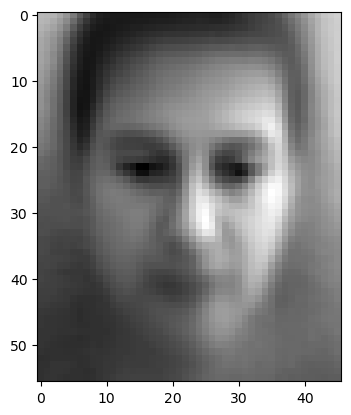

In [6]:
# mean face
mean_face = np.mean(X_train, axis=0)
plt.imshow(mean_face.reshape(46, 56).T, cmap='gray')
plt.show()

In [7]:
# S = AA^T / N (pixels * pixels)
A = X_train - mean_face
A_test = X_test - mean_face
S_a = A.T @ A / X_train.shape[0] # M x M

# eigenvalues and eigenvectors
eigenvalues_a, eigenvectors_a = np.linalg.eigh(S_a)

# sort eigenvectors in descending order by eigenvalues
idx = eigenvalues_a.argsort()[::-1]
eigenvalues_a = eigenvalues_a[idx]
eigenvectors_a = eigenvectors_a[:,idx]


### Apply PCA to reduce dimensionality

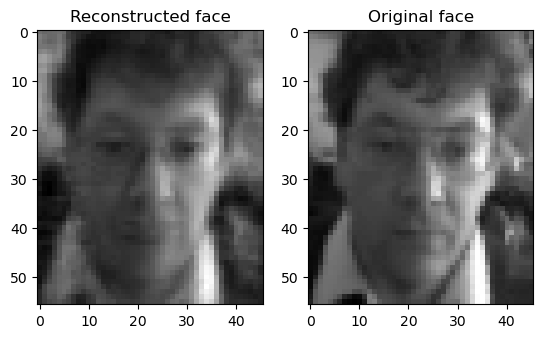

Accuracy of a: 0.5865384615384616


In [8]:
k = 100
U = eigenvectors_a[:, :k]
X_pca_a = A @ U # project data to k-dimensions

# reconstruct face
reconstruct_face = X_pca_a[0] @ U.T + mean_face
plt.subplot(1, 2, 1)
plt.imshow(reconstruct_face.real.reshape(46, 56).T, cmap='gray')
plt.title('Reconstructed face')
plt.subplot(1, 2, 2)
plt.imshow(X_train[0].reshape(46, 56).T, cmap='gray')
plt.title('Original face')
plt.show()

# compare to test data
A_test_a = A_test @ U
y_pred = []
for i in range(A_test_a.shape[0]):
    distances = np.linalg.norm(A_test_a[i] - X_pca_a, axis=1)
    y_pred.append(y_train[np.argmin(distances)])
y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of a: {accuracy}')




## Method b. Applying PCA to $S = \frac{1}{N}A^TA$

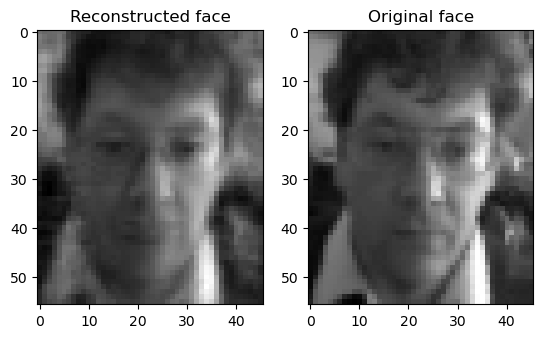

Accuracy of b: 0.5865384615384616


In [9]:
S_b = (A @ A.T) / X_train.shape[0] # N x N
eigenvalues_b, eigenvectors_b = np.linalg.eigh(S_b)

# sort eigenvalues and eigenvectors
idx = eigenvalues_b.argsort()[::-1]
eigenvalues_b = eigenvalues_b[idx]
eigenvectors_b = eigenvectors_b[:,idx]
eigenvectors_b = A.T @ eigenvectors_b

# normalize eigenvectors to unit length
eigenvectors_b = eigenvectors_b / np.linalg.norm(eigenvectors_b, axis=0)

V = eigenvectors_b[:, :k]
X_pca_b = A @ V

# reconstruct face
reconstruct_face = X_pca_b[0] @ V.T + mean_face
plt.subplot(1, 2, 1)
plt.imshow(reconstruct_face.real.reshape(46, 56).T, cmap='gray')
plt.title('Reconstructed face')
plt.subplot(1, 2, 2)
plt.imshow(X_train[0].reshape(46, 56).T, cmap='gray')
plt.title('Original face')
plt.show()

# compare to test data
A_test_b = A_test @ V
y_pred = []
for i in range(A_test_b.shape[0]):
    distances = np.linalg.norm(A_test_b[i] - X_pca_b, axis=1)
    y_pred.append(y_train[np.argmin(distances)])
y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of b: {accuracy}')

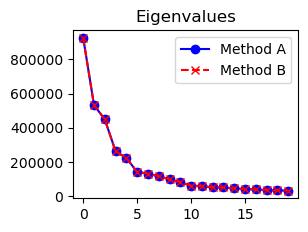

In [10]:
# eigenvalues comparison
plt.subplot(2, 2, 2)
plt.plot(eigenvalues_a[:20], 'b-o', label='Method A')
plt.plot(eigenvalues_b[:20], 'r--x', label='Method B')
plt.title('Eigenvalues')
plt.legend()

## Application of Eigenfaces

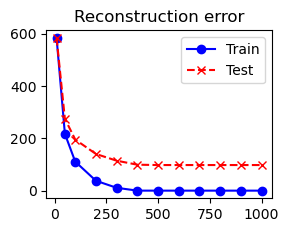

In [11]:
# reconstruction error with different k
reconstruction_error = []
k_list = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
train_errors = []
test_errors = []
for k in k_list:
    U = eigenvectors_b[:, :k]
    X_pca = A @ U
    A_test_pca = A_test @ U
    train_error = np.mean(np.square(A - X_pca @ U.T))
    test_error = np.mean(np.square(A_test - A_test_pca @ U.T))
    train_errors.append(train_error)
    test_errors.append(test_error)
plt.subplot(2, 2, 1)
plt.plot(k_list, train_errors, 'b-o', label='Train')
plt.plot(k_list, test_errors, 'r--x', label='Test')
plt.title('Reconstruction error')
plt.legend()


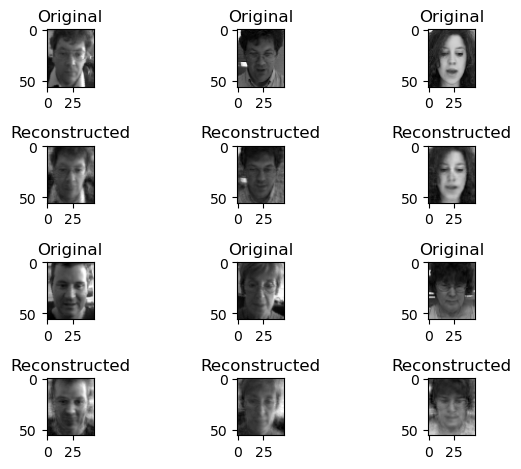

In [12]:
U = eigenvectors_b[:, :100]
X_pca = A @ U
A_test_pca = A_test @ U
# draw 3 images from train or test set and their reconstructions
for i in range(3):
    plt.subplot(4, 3, i+1)
    plt.imshow(X_train[i].reshape(46, 56).T, cmap='gray')
    plt.title('Original')
    plt.subplot(4, 3, i+4)
    reconstruct_face = X_pca[i] @ V.T + mean_face
    plt.imshow(reconstruct_face.real.reshape(46, 56).T, cmap='gray')
    plt.title('Reconstructed')
    plt.subplot(4, 3, i+7)
    plt.imshow(X_test[i].reshape(46, 56).T, cmap='gray')
    plt.title('Original')
    plt.subplot(4, 3, i+10)
    reconstruct_face = A_test_pca[i] @ V.T + mean_face
    plt.imshow(reconstruct_face.real.reshape(46, 56).T, cmap='gray')
    plt.title('Reconstructed')
plt.tight_layout()
plt.show()

## KNN classification method

Text(0.5, 1.0, 'KNN accuracy')

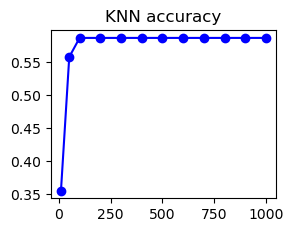

In [13]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
accuracy_list = []
for k in k_list:
    knn.fit(X_pca[:, :k], y_train.ravel())
    y_pred = knn.predict(A_test_pca[:, :k])
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
plt.subplot(2, 2, 4)
plt.plot(k_list, accuracy_list, 'b-o')
plt.title('KNN accuracy')


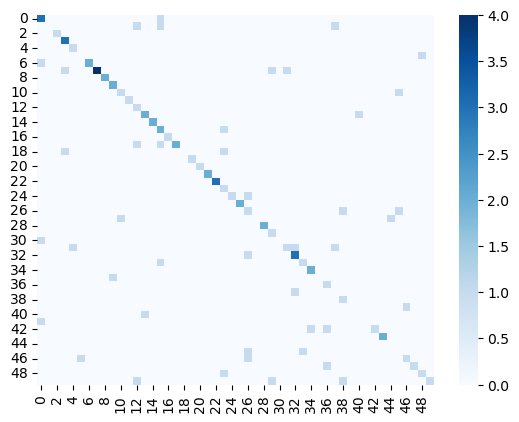

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues')
plt.show()

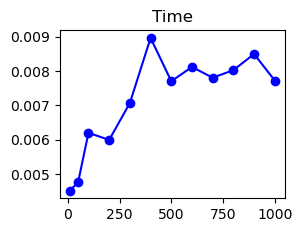

In [15]:
# time and accuracy comparison
times = []
accuracy_list = []

for k in k_list:
    start = time.time()
    U = eigenvectors_b[:, :k]
    X_pca_k = A @ U
    A_test_pca_k = A_test @ U
    knn.fit(X_pca_k, y_train.ravel())
    y_pred = knn.predict(A_test_pca_k)
    end = time.time()
    times.append(end - start)

plt.subplot(2, 2, 3)
plt.plot(k_list, times, 'b-o')
plt.title('Time')
plt.show()

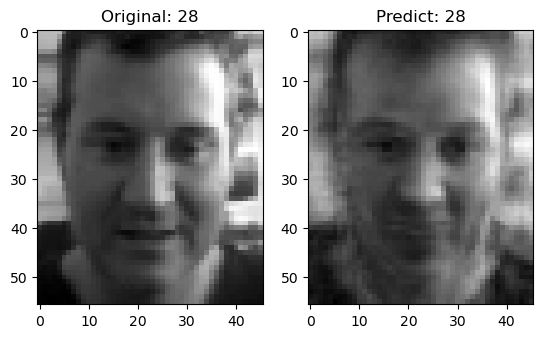

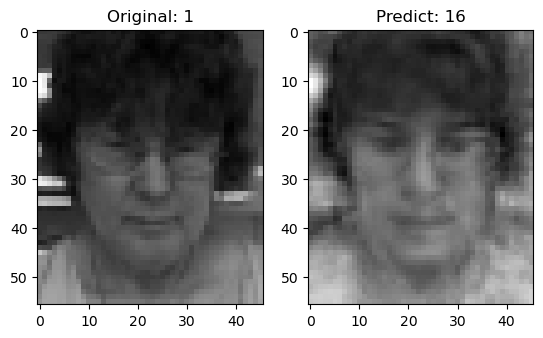

In [16]:
# visualize success and failure cases
success = []
failure = []
k = 100
knn.fit(X_pca[:, :k], y_train.ravel())
y_pred = knn.predict(A_test_pca[:, :k])

for i in range(A_test_pca.shape[0]):
    if y_test[i] == y_pred[i]:
        success.append(i)
    else:
        failure.append(i)

#success case
success_idx = success[0]
plt.subplot(1, 2, 1)
plt.imshow(X_test[success_idx].reshape(46, 56).T, cmap='gray')
plt.title('Original: %d' % y_test[success_idx])
plt.subplot(1, 2, 2)
reconstruct_face = A_test_pca[success_idx] @ V.T + mean_face
plt.imshow(reconstruct_face.real.reshape(46, 56).T, cmap='gray')
plt.title('Predict: %d' % y_pred[success_idx])
plt.show()

#failure case
failure_idx = failure[0]
plt.subplot(1, 2, 1)
plt.imshow(X_test[failure_idx].reshape(46, 56).T, cmap='gray')
plt.title('Original: %d'% y_test[failure_idx])
plt.subplot(1, 2, 2)
reconstruct_face = A_test_pca[failure_idx] @ V.T + mean_face
plt.imshow(reconstruct_face.real.reshape(46, 56).T, cmap='gray')
plt.title('Predict: %d' % y_pred[failure_idx])
plt.show()